# Model for predicting flight delays 

This notebook will serve as a single notebook to run all the desired models on a given dataset

## 1. Initial Setup

In [0]:
from pyspark import SparkContext
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType
from pyspark.sql import SQLContext, SparkSession

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql import types
SEED = 7

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image

In [0]:
# Enable for pretty viewing of tables
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [0]:
username = dbutils.notebook.entry_point.getDbutils().notebook().getContext().tags().apply('user')
userhome = 'dbfs:/user/' + username
print(userhome)
project_path = userhome + "/FinalProject/"
display(dbutils.fs.ls(project_path))

dbfs:/user/chitra.agastya@ischool.berkeley.edu

path,name,size
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/Chitra_feature_data/,Chitra_feature_data/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airline_singleday.parquet/,airline_singleday.parquet/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airlines_3m_features_ext.parquet/,airlines_3m_features_ext.parquet/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airlines_3m_full_features.parquet/,airlines_3m_full_features.parquet/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airlines_weather_data/,airlines_weather_data/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport-timezones.csv,airport-timezones.csv,439779
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges/,airport_edges/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges_1_year/,airport_edges_1_year/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges_3_month/,airport_edges_3_month/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges_4_year/,airport_edges_4_year/,0


In [0]:
# Load training, validation and test data directories
train_dir = "train.parquet"
dev_dir = "dev.parquet"
test_dir = "test.parquet"
mode = 'full'
outcome = 'is_delayed'
run = 'full'

save_path = project_path + "Chitra_feature_data"
loadPipelineFromFile = False
savePipeline = False

print(f'Project Path: {project_path} mode:{mode}')

Project Path: dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/ mode:full

In [0]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, Imputer, StandardScaler, FeatureHasher, SQLTransformer
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Load the training data
def loadData(dirName, viewName):
  data = spark.read.option("header", "true").parquet(f'{project_path}{dirName}/*.parquet')
  data.createOrReplaceTempView(viewName)
  return data

def preProcessData(dff, outcome = 'is_delayed'):
  
  # Take care of unknown weather values
  # Convert pressure 9999 to null
  for col in [x for x in dff.columns if x.endswith('_pressure')]:
    dff = dff.withColumn(col, f.when(f.col(col) == 9999, None).otherwise(f.col(col)))
    
  # Convert ceiling 99999 to None
  for col in [x for x in dff.columns if x.endswith('_ceiling')]:
    dff = dff.withColumn(col, f.when(f.col(col) == 99999, None).otherwise(f.col(col)))
    
  # Convert wind_speed 999.9 to None
  for col in [x for x in dff.columns if x.endswith('_wind_speed')]:
    dff = dff.withColumn(col, f.when(f.col(col) == 999.9, None).otherwise(f.col(col)))
    
  # Convert wind_speed 999.9 to None
  for col in [x for x in dff.columns if x.endswith('_wind_angle')]:
    dff = dff.withColumn(col, f.when(f.col(col) == 999, None).otherwise(f.col(col)))
  
  # Convert visibility and ceiling to integer values
  for col in [x for x in dff.columns if x.endswith('_visibility') or x.endswith('_ceiling')]:
    dff = dff.withColumn(col, dff[col].cast(IntegerType()))

  # Convert temperature and dewpoint to Kelvin by adding 273
  for col in [x for x in dff.columns if x.endswith('_temperature') or x.endswith('_dewpoint')]:
    dff = dff.withColumn(col, dff[col] + 273)
    
  dff = dff.withColumn('time_blk', ((dff['dep_blk'].cast(IntegerType()) + 2) / 8).cast(IntegerType()))
  # cast the equipment_delayed to numeric int
  dff = dff.withColumn('equipment_delayed', dff['equipment_delayed'].cast(IntegerType()))
  
  # create the outcome column
  dff = dff.withColumn(outcome, f.when(f.col('dep_del15') == 1, 1)
                                .otherwise(0)
                      )
  return dff

# a more parallel attempt
def createStages2(dff, outcome, run = 'basic'):
  stages = []
  
  #Preprocess the Data
  dff = preProcessData(dff).cache()
  
  # Get the categorical columns
  categoricalColumnsNoAirports = ['month', 'day_of_month', 'day_of_week', 'op_carrier', 'dep_blk']
  # add equipement_delayed for non-basic runs
  if run != 'basic':
    categoricalColumnsNoAirports += ['equipment_delayed']
  # and our full set includes origin and destination for string indexing 
  filterColumns = ['origin', 'destination'] 
  categoricalColumns = filterColumns + categoricalColumnsNoAirports
  
  
  # index their strings. sadly, no parallel method for that
  stringIndexers = [StringIndexer(inputCol = col, outputCol = col + 'Index').setHandleInvalid("keep") for col in categoricalColumns]
  stages += stringIndexers
          
  # one-hot encode the categorical columns
  encoder = OneHotEncoder(inputCols=[col + 'Index' for col in categoricalColumnsNoAirports], \
                          outputCols=[col + "classVec" for col in categoricalColumnsNoAirports], \
                          handleInvalid='keep')
  stages += [encoder]
  
  # add the outcome label
  label_stringIdx = StringIndexer(inputCol = outcome, outputCol = 'label').setHandleInvalid("keep")
  stages += [label_stringIdx]

  # Get numeric columns
  #[x for x in dff.columns if x.startswith('avg_')] + 
  numericCols = ['distance', 'dest_pagerank', 'src_pagerank', 'weight']
  if run != 'basic':
      numericCols += [x for x in dff.columns if (x.startswith('origin_') or x.startswith('destination_'))]
  
  # impute, vectorize and scale numeric columns
  imputedCols = [col+"_Imputed" for col in numericCols]
  imputer = Imputer(inputCols=numericCols, outputCols=imputedCols, strategy='mean')
  
  # from our runs, it looks like the parallel imputer might not have a deterministic output column order
  # make sure the resulting columns are in a defined order
  cols = ['label', 'originIndex', 'destinationIndex'] + [c+"classVec" for c in categoricalColumnsNoAirports] + imputedCols
  col_string = ','.join(cols)
  feature_projector = SQLTransformer(statement=f"SELECT {col_string} FROM __THIS__")
  
  # now convert some of this into a vector and scale its dimensions independently
  assembler = VectorAssembler(inputCols=imputedCols,outputCol="numeric_vect", handleInvalid='keep')
  scaler = StandardScaler(inputCol="numeric_vect", outputCol="numeric_scaled")
  stages += [imputer, feature_projector, assembler, scaler]
  
  # put all the features together
  feature_assembler = VectorAssembler(inputCols=[c + "classVec" for c in categoricalColumnsNoAirports] + ["numeric_scaled"], outputCol="features")
  hash_assembler = VectorAssembler(inputCols=["originIndex", "destinationIndex", "numeric_scaled"], outputCol="hash_vector")
  # final projection of columns, review this carefully
  outputCols = ['label', 'originIndex', 'destinationIndex', 'hash_vector', 'numeric_scaled', 'features'] + [c + "classVec" for c in categoricalColumnsNoAirports]
  col_string = ','.join(outputCols)
  final_projector = SQLTransformer(statement=f"SELECT {col_string} FROM __THIS__")
    
  stages += [feature_assembler, hash_assembler, final_projector]
  
  return stages

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
def trainModel (type, labelCol, featuresCol, data):
    classifier = None
    model = None
    if type == 'DecisionTree':
        classifier = DecisionTreeClassifier(labelCol= labelCol, featuresCol = featuresCol)
    elif type == 'RandomForest':
        classifier = RandomForestClassifier(featuresCol = featuresCol, labelCol = labelCol, numTrees = 25, maxDepth = 12)
    elif type == 'GBT':
        classifier = GBTClassifier(featuresCol = featuresCol, labelCol = labelCol, maxIter = 20, maxDepth = 8, maxBins = 60) #based on CV grid search 20,8,60 
    elif type == 'Logistic':
        classifier = LogisticRegression(featuresCol = featuresCol, labelCol = labelCol, maxIter= 25, regParam= 0.3, elasticNetParam= 0.8) 
    
    if classifier:
        model = classifier.fit(data)
        
    return model
        
def predictAndEvaluate (data, model, evaluate = True):
    predictions = None
    if model:
        predictions = model.transform(data)
        
    if predictions and evaluate:
        evaluator = BinaryClassificationEvaluator(labelCol="label")
        print("Test Area Under ROC: {}".format(str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"}))))
        print("Test Area Under PR: {}".format(str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}))))

        evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
        accuracy = evaluator.evaluate(predictions)
        print("Accuracy = %g " % (accuracy))
        print("Test Error = %g " % (1.0 - accuracy))
        
    if predictions:
      evaluateModel(predictions.select('prediction', 'label').rdd.map(tuple), [0,1])

    return predictions

def evaluateModel(predictionAndLabels, labels):
    # Instantiate metrics object
    metrics = MulticlassMetrics(predictionAndLabels)
    
    # Confusion Matrix
    print("Confusion matrix:")
    print(metrics.confusionMatrix().toArray())
    plot_confusion_matrix(metrics.confusionMatrix().toArray(), target_names = ['On-time', 'Delayed'])

    # Overall statistics
    precision = metrics.precision(1.0)
    recall = metrics.recall(1.0)
    f1Score = metrics.fMeasure(1.0)
    print("Summary Stats")
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1 Score = %s" % f1Score)

    # Statistics by class
    for label in sorted(labels):
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))
        print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(float(label), beta=1.0)))

    # Weighted stats
    print("Weighted recall = %s" % metrics.weightedRecall)
    print("Weighted precision = %s" % metrics.weightedPrecision)
    print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
    print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
    print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)
    
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    
    numericCols = ['distance', 'dest_pagerank', 'src_pagerank', 'weight'] + \
      [x for x in train_data.columns if x.startswith('avg_')] + \
      [x for x in train_data.columns if (x.startswith('origin_') or x.startswith('destination_'))]
    
    for i in dataset.schema["features"].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    varlist['friendly_name'] = varlist['idx'].apply(lambda x: numericCols[x - 96] if x > 95 else None)
    varlist['friendly_name'] = varlist['friendly_name'].mask(pd.isnull, varlist['name'])
    return(varlist.sort_values('score', ascending = False))

# 2. Data

### 2.1 Load the Data

In [0]:
train_data = preProcessData(loadData(train_dir, 'train_data')).cache()
# only use data between 4 to 7 pm i.e. dep_blk is 16 to 19
train_data = train_data.where('dep_blk in (17,18)').cache()

dev_data = preProcessData(loadData(dev_dir, 'dev_data'))
test_data = preProcessData(loadData(test_dir, 'test_data'))

In [0]:
display(train_data)

origin,destination,year,month,day_of_month,day_of_week,crs_dep_time_utc,naive_crs_arr_time_utc,tail_num,op_carrier,distance,dep_blk,dep_del15,nas_delay,carrier_delay,weather_delay,security_delay,late_aircraft_delay,arr_delay,crs_arr_time_utc,arr_hour_utc,dep_hour_utc,hour,del_tail_num,equipment_delayed,dest_pagerank,src_pagerank,weight,avg_trips_per_day,avg_tp_per_day,avg_flights_per_day,avg_car_per_day,avg_car_flights_per_day,origin_2_wind_angle,origin_2_wind_speed,origin_2_ceiling,origin_2_visibility,origin_2_temperature,origin_2_dewpoint,origin_2_pressure,origin_3_wind_angle,origin_3_wind_speed,origin_3_ceiling,origin_3_visibility,origin_3_temperature,origin_3_dewpoint,origin_3_pressure,origin_4_wind_angle,origin_4_wind_speed,origin_4_ceiling,origin_4_visibility,origin_4_temperature,origin_4_dewpoint,origin_4_pressure,origin_5_wind_angle,origin_5_wind_speed,origin_5_ceiling,origin_5_visibility,origin_5_temperature,origin_5_dewpoint,origin_5_pressure,destination_2_wind_angle,destination_2_wind_speed,destination_2_ceiling,destination_2_visibility,destination_2_temperature,destination_2_dewpoint,destination_2_pressure,destination_3_wind_angle,destination_3_wind_speed,destination_3_ceiling,destination_3_visibility,destination_3_temperature,destination_3_dewpoint,destination_3_pressure,destination_4_wind_angle,destination_4_wind_speed,destination_4_ceiling,destination_4_visibility,destination_4_temperature,destination_4_dewpoint,destination_4_pressure,destination_5_wind_angle,destination_5_wind_speed,destination_5_ceiling,destination_5_visibility,destination_5_temperature,destination_5_dewpoint,destination_5_pressure,time_blk,is_delayed
AEX,IAH,2015,12,10,4,2015-12-10T23:24:00.000+0000,2015-12-11T00:32:00.000+0000,N12163,EV,190.0,17,0.0,null,null,null,null,null,-20.0,2015-12-11T00:32:00.000+0000,2015-12-11T00:00:00.000+0000,2015-12-10T23:00:00.000+0000,null,null,0,6.074249511495245,0.3143358531845712,0.3333333333333333,1.0,8,2.67,6,2.67,190.0,4.1,22000,16093,296.3,291.3,1010.3,160.0,4.6,22000,16093,296.3,291.3,1010.8,215.0,5.1,457,12875,294.7,290.8,1012.2,195.0,6.2,366,11265,294.0,291.0,1013.3,200.0,4.6,7620,16093,298.6,289.7,1009.1,200.0,5.1,7620,16093,298.6,290.8,1010.1,225.0,5.1,7620,16093,297.0,291.0,1011.5,220.0,4.6,671,16093,296.3,291.3,1013.0,2,0
ATL,DAL,2018,8,2,4,2018-08-02T22:05:00.000+0000,2018-08-02T23:20:00.000+0000,N8536Z,WN,721.0,18,0.0,null,null,null,null,null,-11.0,2018-08-02T23:20:00.000+0000,2018-08-02T23:00:00.000+0000,2018-08-02T22:00:00.000+0000,null,null,0,2.656749471489397,9.031150214803475,0.005847953216374269,1.03,1037,9.18,117,4.59,319.75,4.1,213,11265,284.0,284.0,1000.9,564.5,2.6,152,16093,284.0,284.0,1001.1,165.0,3.1,610,16093,297.0,294.0,1017.4,663.4,2.6,122,11265,283.0,283.0,1002.0,999.0,2.1,22000,16093,308.6,286.9,1014.6,350.0,2.6,22000,16093,308.0,287.4,1015.2,999.0,3.1,22000,16093,306.9,288.0,1015.9,130.0,3.6,22000,16093,305.2,289.1,1016.5,2,0
ATL,PHL,2018,8,9,4,2018-08-09T22:47:00.000+0000,2018-08-10T01:02:00.000+0000,N901DE,DL,666.0,18,1.0,0.0,0.0,22.0,0.0,232.0,254.0,2018-08-10T01:02:00.000+0000,2018-08-10T01:00:00.000+0000,2018-08-09T22:00:00.000+0000,null,null,0,3.955577992319959,9.031150214803475,0.005847953216374269,2.6,1037,18.89,669,9.88,321.125,6.7,914,8047,297.0,294.0,1016.1,296.6666666666667,5.1,null,9656,301.9,294.7,1016.0,310.0,4.1,22000,16093,305.2,296.3,1016.5,280.0,4.1,22000,16093,304.1,295.8,1017.7,320.0,4.6,22000,16093,303.6,291.9,1009.9,300.0,5.1,22000,16093,303.6,290.8,1010.0,360.0,4.6,22000,16093,303.6,292.4,1010.4,310.0,5.1,22000,16093,301.9,292.4,1010.7,2,1
BOS,ATL,2015,4,5,7,2015-04-05T21:15:00.000+0000,2015-04-06T00:15:00.000+0000,N909DE,DL,946.0,17,0.0,null,null,null,null,null,-5.0,2015-04-06T00:15:00.000+0000,2015-04-06T00:00:00.000+0000,2015-04-05T21:00:00.000+0000,null,null,0,9.031150214803475,2.909164282524018,0.014705882352941176,1.04,346,16.16,44,10.84,270.0,8.8,1981,16093,280.2,266.3,1019.4,270.0,9.8,2134,16093,280.2,264.1,1019.5,260.0,8.2,7620,16093,282.4,261.3

In [0]:
train_data.count()

Out[9]: 2513146

In [0]:
display(train_data.select('dep_blk').distinct())

dep_blk
17
18


In [0]:
dev_data.groupBy(outcome).count().show()

+----------+------+
is_delayed| count|
+----------+------+
 1| 85671|
 0|315788|
+----------+------+

In [0]:
display(train_data.limit(10))

origin,destination,year,month,day_of_month,day_of_week,crs_dep_time_utc,naive_crs_arr_time_utc,tail_num,op_carrier,distance,dep_blk,dep_del15,nas_delay,carrier_delay,weather_delay,security_delay,late_aircraft_delay,arr_delay,crs_arr_time_utc,arr_hour_utc,dep_hour_utc,hour,del_tail_num,equipment_delayed,dest_pagerank,src_pagerank,weight,avg_trips_per_day,avg_tp_per_day,avg_flights_per_day,avg_car_per_day,avg_car_flights_per_day,origin_2_wind_angle,origin_2_wind_speed,origin_2_ceiling,origin_2_visibility,origin_2_temperature,origin_2_dewpoint,origin_2_pressure,origin_3_wind_angle,origin_3_wind_speed,origin_3_ceiling,origin_3_visibility,origin_3_temperature,origin_3_dewpoint,origin_3_pressure,origin_4_wind_angle,origin_4_wind_speed,origin_4_ceiling,origin_4_visibility,origin_4_temperature,origin_4_dewpoint,origin_4_pressure,origin_5_wind_angle,origin_5_wind_speed,origin_5_ceiling,origin_5_visibility,origin_5_temperature,origin_5_dewpoint,origin_5_pressure,destination_2_wind_angle,destination_2_wind_speed,destination_2_ceiling,destination_2_visibility,destination_2_temperature,destination_2_dewpoint,destination_2_pressure,destination_3_wind_angle,destination_3_wind_speed,destination_3_ceiling,destination_3_visibility,destination_3_temperature,destination_3_dewpoint,destination_3_pressure,destination_4_wind_angle,destination_4_wind_speed,destination_4_ceiling,destination_4_visibility,destination_4_temperature,destination_4_dewpoint,destination_4_pressure,destination_5_wind_angle,destination_5_wind_speed,destination_5_ceiling,destination_5_visibility,destination_5_temperature,destination_5_dewpoint,destination_5_pressure,time_blk,is_delayed
AEX,IAH,2015,12,10,4,2015-12-10T23:24:00.000+0000,2015-12-11T00:32:00.000+0000,N12163,EV,190.0,17,0.0,null,null,null,null,null,-20.0,2015-12-11T00:32:00.000+0000,2015-12-11T00:00:00.000+0000,2015-12-10T23:00:00.000+0000,null,null,0,6.074249511495245,0.3143358531845712,0.3333333333333333,1.0,8,2.67,6,2.67,190.0,4.1,22000,16093,296.3,291.3,1010.3,160.0,4.6,22000,16093,296.3,291.3,1010.8,215.0,5.1,457,12875,294.7,290.8,1012.2,195.0,6.2,366,11265,294.0,291.0,1013.3,200.0,4.6,7620,16093,298.6,289.7,1009.1,200.0,5.1,7620,16093,298.6,290.8,1010.1,225.0,5.1,7620,16093,297.0,291.0,1011.5,220.0,4.6,671,16093,296.3,291.3,1013.0,2,0
ATL,DAL,2018,8,2,4,2018-08-02T22:05:00.000+0000,2018-08-02T23:20:00.000+0000,N8536Z,WN,721.0,18,0.0,null,null,null,null,null,-11.0,2018-08-02T23:20:00.000+0000,2018-08-02T23:00:00.000+0000,2018-08-02T22:00:00.000+0000,null,null,0,2.656749471489397,9.031150214803475,0.005847953216374269,1.03,1037,9.18,117,4.59,319.75,4.1,213,11265,284.0,284.0,1000.9,564.5,2.6,152,16093,284.0,284.0,1001.1,165.0,3.1,610,16093,297.0,294.0,1017.4,663.4,2.6,122,11265,283.0,283.0,1002.0,999.0,2.1,22000,16093,308.6,286.9,1014.6,350.0,2.6,22000,16093,308.0,287.4,1015.2,999.0,3.1,22000,16093,306.9,288.0,1015.9,130.0,3.6,22000,16093,305.2,289.1,1016.5,2,0
ATL,PHL,2018,8,9,4,2018-08-09T22:47:00.000+0000,2018-08-10T01:02:00.000+0000,N901DE,DL,666.0,18,1.0,0.0,0.0,22.0,0.0,232.0,254.0,2018-08-10T01:02:00.000+0000,2018-08-10T01:00:00.000+0000,2018-08-09T22:00:00.000+0000,null,null,0,3.955577992319959,9.031150214803475,0.005847953216374269,2.6,1037,18.89,669,9.88,321.125,6.7,914,8047,297.0,294.0,1016.1,296.6666666666667,5.1,null,9656,301.9,294.7,1016.0,310.0,4.1,22000,16093,305.2,296.3,1016.5,280.0,4.1,22000,16093,304.1,295.8,1017.7,320.0,4.6,22000,16093,303.6,291.9,1009.9,300.0,5.1,22000,16093,303.6,290.8,1010.0,360.0,4.6,22000,16093,303.6,292.4,1010.4,310.0,5.1,22000,16093,301.9,292.4,1010.7,2,1
BOS,ATL,2015,4,5,7,2015-04-05T21:15:00.000+0000,2015-04-06T00:15:00.000+0000,N909DE,DL,946.0,17,0.0,null,null,null,null,null,-5.0,2015-04-06T00:15:00.000+0000,2015-04-06T00:00:00.000+0000,2015-04-05T21:00:00.000+0000,null,null,0,9.031150214803475,2.909164282524018,0.014705882352941176,1.04,346,16.16,44,10.84,270.0,8.8,1981,16093,280.2,266.3,1019.4,270.0,9.8,2134,16093,280.2,264.1,1019.5,260.0,8.2,7620,16093,282.4,261.3

# 3. Create and Run Pipeline

Test Area Under ROC: 0.6811428711593858
Test Area Under PR: 0.3957551991307591
Accuracy = 0.787287 
Test Error = 0.212713 
Confusion matrix:
[[214695. 939.]
 [ 57722. 2419.]]

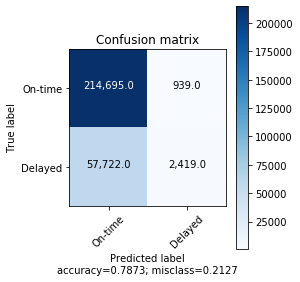

Summary Stats
Precision = 0.720369267421084
Recall = 0.0402221446267937
F1 Score = 0.0761901762232476
Class 0 precision = 0.7881116083063833
Class 0 recall = 0.9956453991485573
Class 0 F1 Measure = 0.8798055940875031
Class 1 precision = 0.720369267421084
Class 1 recall = 0.0402221446267937
Class 1 F1 Measure = 0.0761901762232476
Weighted recall = 0.7872867373764845
Weighted precision = 0.7733383615538394
Weighted F(1) Score = 0.704553178727974
Weighted F(0.5) Score = 0.6788989857263337
Weighted false positive rate = 0.7514191936011334

In [0]:
from pyspark.ml import Pipeline, PipelineModel
pipelineModel = None

# E2E Pipeline
stages = createStages2(train_data, outcome, run)
gbt = GBTClassifier(maxIter = 20, maxDepth = 4, maxBins = 27 )
stages += [gbt]

pipeline = Pipeline(stages = stages)

#Transform and train the model
model = pipeline.fit(train_data)

#Evaluate model for only depl_blk 16-18
predictions = predictAndEvaluate(dev_data.where('dep_blk in (17,18)'), model)


Test Area Under ROC: 0.6635683065566512
Test Area Under PR: 0.38593085636347413
Accuracy = 0.782505 
Test Error = 0.217495 
Confusion matrix:
[[635459. 2746.]
 [175979. 7559.]]

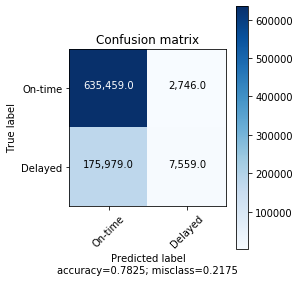

Summary Stats
Precision = 0.7335274138767589
Recall = 0.04118493173075875
F1 Score = 0.07799095144008295
Class 0 precision = 0.7831269918342498
Class 0 recall = 0.9956973072915443
Class 0 F1 Measure = 0.8767110247143608
Class 1 precision = 0.7335274138767589
Class 1 recall = 0.04118493173075875
Class 1 F1 Measure = 0.07799095144008295
Weighted recall = 0.7825049924368082
Weighted precision = 0.7720488234298193
Weighted F(1) Score = 0.6983152430543839
Weighted F(0.5) Score = 0.6729002142475404
Weighted false positive rate = 0.7456227534145051

In [0]:
#Evaluate model for test_data for only the busy block
predictions = predictAndEvaluate(test_data.where('dep_blk in (17,18)').cache(), model)